Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/My Drive/Colab Notebooks/c247'

from all_models import *
from all_solvers import *
from all_functions import *

import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import KFold
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

device = torch.device('cuda' if torch.cuda.is_available() else'cpu')

/content/drive/My Drive/Colab Notebooks/c247
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load Data

In [ ]:
# normal data
X_test, y_test, person_train_valid, X_train_valid, y_train_valid, person_test = import_data()


# DeepConv

-- Fold [1/5] --
Epoch [10], Training loss [0.9310], Training accuracy [62.71%]
Epoch [10], Validation loss [1.0856], Validation accuracy [55.32%]
Epoch [20], Training loss [0.6983], Training accuracy [74.70%]
Epoch [20], Validation loss [0.9461], Validation accuracy [62.88%]
Epoch [30], Training loss [0.5092], Training accuracy [83.33%]
Epoch [30], Validation loss [0.8592], Validation accuracy [65.25%]
Epoch [40], Training loss [0.3599], Training accuracy [89.36%]
Epoch [40], Validation loss [0.8897], Validation accuracy [64.78%]
Epoch [50], Training loss [0.2418], Training accuracy [94.74%]
Epoch [50], Validation loss [0.8710], Validation accuracy [66.19%]
Epoch [60], Training loss [0.1784], Training accuracy [96.39%]
Epoch [60], Validation loss [0.8892], Validation accuracy [67.14%]
Epoch [70], Training loss [0.1351], Training accuracy [97.70%]
Epoch [70], Validation loss [0.8588], Validation accuracy [69.03%]
Epoch [80], Training loss [0.1006], Training accuracy [98.23%]
Epoch [80]

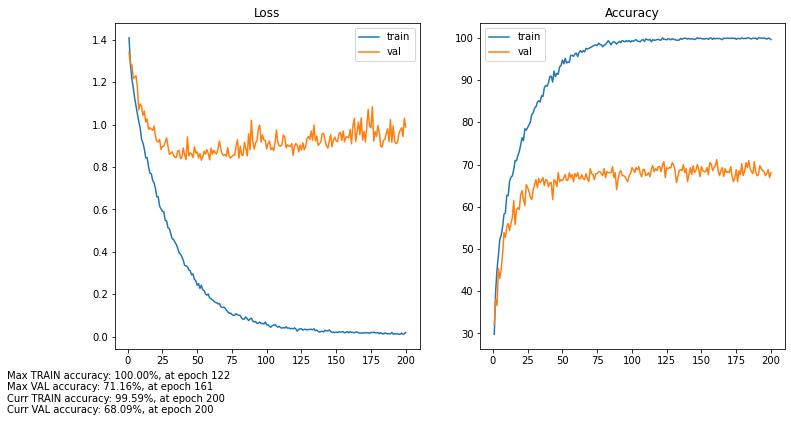

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test)

  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.2, trial_length=1000).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))




# DeepConv, trialsize 900

-- Fold [1/5] --
Epoch [10], Training loss [1.0348], Training accuracy [56.44%]
Epoch [10], Validation loss [1.1566], Validation accuracy [53.07%]
Epoch [20], Training loss [0.7992], Training accuracy [68.71%]
Epoch [20], Validation loss [0.9800], Validation accuracy [60.52%]
Epoch [30], Training loss [0.6426], Training accuracy [74.82%]
Epoch [30], Validation loss [0.9047], Validation accuracy [63.48%]
Epoch [40], Training loss [0.5200], Training accuracy [80.47%]
Epoch [40], Validation loss [0.8922], Validation accuracy [63.83%]
Epoch [50], Training loss [0.4063], Training accuracy [86.29%]
Epoch [50], Validation loss [0.9360], Validation accuracy [63.59%]
Epoch [60], Training loss [0.3375], Training accuracy [88.65%]
Epoch [60], Validation loss [1.0029], Validation accuracy [62.77%]
Epoch [70], Training loss [0.2614], Training accuracy [92.11%]
Epoch [70], Validation loss [0.9806], Validation accuracy [63.36%]
Epoch [80], Training loss [0.2134], Training accuracy [93.35%]
Epoch [80]

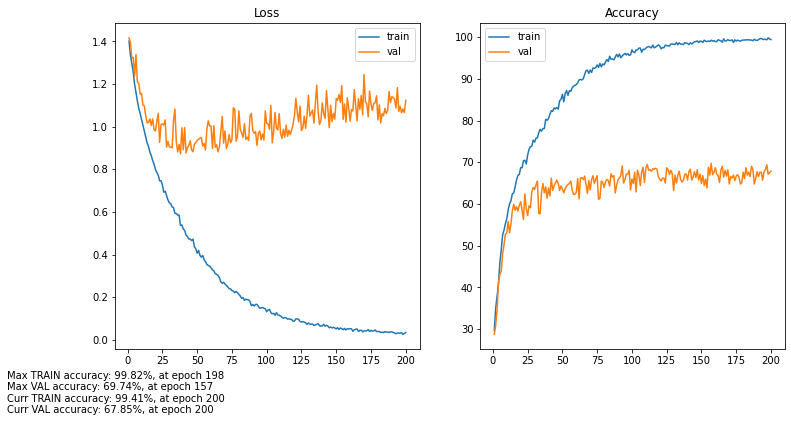

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 90
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.2, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))



# DeepConv, trialsize 800

-- Fold [1/5] --
Epoch [10], Training loss [1.0537], Training accuracy [54.87%]
Epoch [10], Validation loss [1.1182], Validation accuracy [52.25%]
Epoch [20], Training loss [0.8513], Training accuracy [65.60%]
Epoch [20], Validation loss [1.0094], Validation accuracy [58.47%]
Epoch [30], Training loss [0.7203], Training accuracy [71.95%]
Epoch [30], Validation loss [0.9705], Validation accuracy [61.15%]
Epoch [40], Training loss [0.5892], Training accuracy [77.42%]
Epoch [40], Validation loss [1.0327], Validation accuracy [60.52%]
Epoch [50], Training loss [0.4866], Training accuracy [81.84%]
Epoch [50], Validation loss [0.9816], Validation accuracy [63.99%]
Epoch [60], Training loss [0.3818], Training accuracy [86.29%]
Epoch [60], Validation loss [1.0923], Validation accuracy [60.60%]
Epoch [70], Training loss [0.3100], Training accuracy [89.42%]
Epoch [70], Validation loss [1.0171], Validation accuracy [65.56%]
Epoch [80], Training loss [0.2481], Training accuracy [91.94%]
Epoch [80]

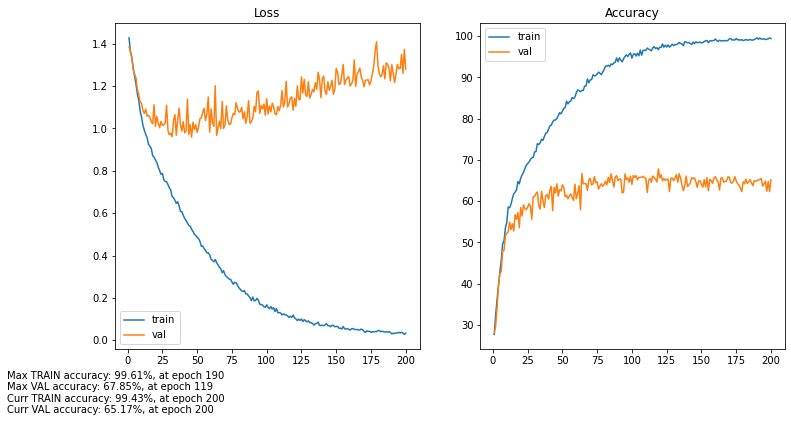

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 800
  stride = 80
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.2, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv, trialsize 700

-- Fold [1/5] --
Epoch [10], Training loss [1.1496], Training accuracy [49.86%]
Epoch [10], Validation loss [1.1500], Validation accuracy [51.11%]
Epoch [20], Training loss [0.9412], Training accuracy [61.31%]
Epoch [20], Validation loss [0.9976], Validation accuracy [56.83%]
Epoch [30], Training loss [0.8099], Training accuracy [67.67%]
Epoch [30], Validation loss [0.9547], Validation accuracy [60.71%]
Epoch [40], Training loss [0.7082], Training accuracy [72.09%]
Epoch [40], Validation loss [0.9244], Validation accuracy [62.65%]
Epoch [50], Training loss [0.6268], Training accuracy [75.63%]
Epoch [50], Validation loss [0.9567], Validation accuracy [61.61%]
Epoch [60], Training loss [0.5292], Training accuracy [80.00%]
Epoch [60], Validation loss [1.0470], Validation accuracy [62.46%]
Epoch [70], Training loss [0.4627], Training accuracy [82.72%]
Epoch [70], Validation loss [0.9435], Validation accuracy [64.49%]
Epoch [80], Training loss [0.4038], Training accuracy [85.73%]
Epoch [80]

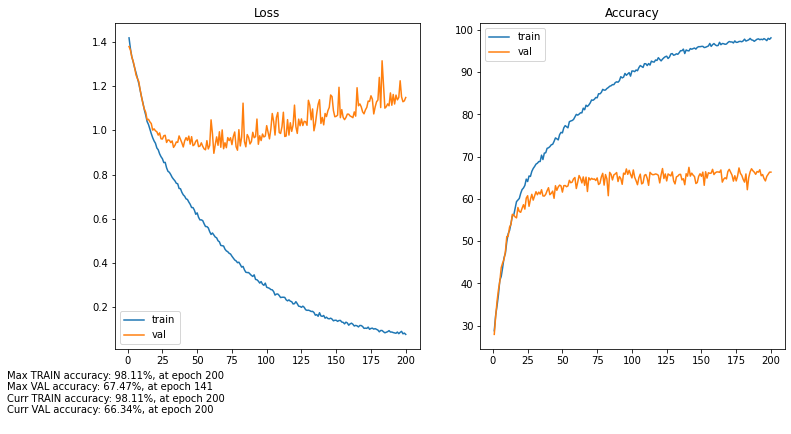

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 700
  stride = 70
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.2, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv, trialsize 600

-- Fold [1/5] --
Epoch [10], Training loss [1.1410], Training accuracy [49.97%]
Epoch [10], Validation loss [1.1210], Validation accuracy [50.22%]
Epoch [20], Training loss [0.9815], Training accuracy [59.41%]
Epoch [20], Validation loss [1.0227], Validation accuracy [56.74%]
Epoch [30], Training loss [0.8738], Training accuracy [64.37%]
Epoch [30], Validation loss [1.0223], Validation accuracy [56.87%]
Epoch [40], Training loss [0.7847], Training accuracy [68.90%]
Epoch [40], Validation loss [0.9727], Validation accuracy [59.17%]
Epoch [50], Training loss [0.7007], Training accuracy [72.63%]
Epoch [50], Validation loss [1.0450], Validation accuracy [58.32%]
Epoch [60], Training loss [0.6111], Training accuracy [76.54%]
Epoch [60], Validation loss [0.9886], Validation accuracy [60.45%]
Epoch [70], Training loss [0.5503], Training accuracy [79.19%]
Epoch [70], Validation loss [1.0107], Validation accuracy [59.74%]
Epoch [80], Training loss [0.4793], Training accuracy [82.08%]
Epoch [80]

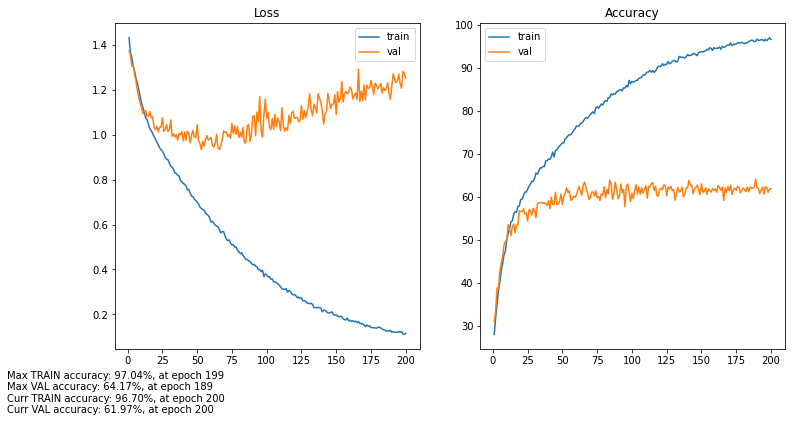

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 600
  stride = 60
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.2, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv, trialsize 500

-- Fold [1/5] --
Epoch [10], Training loss [1.2033], Training accuracy [45.87%]
Epoch [10], Validation loss [1.2221], Validation accuracy [44.92%]
Epoch [20], Training loss [1.0696], Training accuracy [54.47%]
Epoch [20], Validation loss [1.1232], Validation accuracy [51.32%]
Epoch [30], Training loss [0.9908], Training accuracy [58.27%]
Epoch [30], Validation loss [1.0753], Validation accuracy [53.51%]
Epoch [40], Training loss [0.9061], Training accuracy [62.64%]
Epoch [40], Validation loss [1.0618], Validation accuracy [55.45%]
Epoch [50], Training loss [0.8314], Training accuracy [66.44%]
Epoch [50], Validation loss [1.0630], Validation accuracy [56.65%]
Epoch [60], Training loss [0.7615], Training accuracy [69.43%]
Epoch [60], Validation loss [1.0217], Validation accuracy [57.73%]
Epoch [70], Training loss [0.7037], Training accuracy [72.12%]
Epoch [70], Validation loss [1.0158], Validation accuracy [58.44%]
Epoch [80], Training loss [0.6353], Training accuracy [75.48%]
Epoch [80]

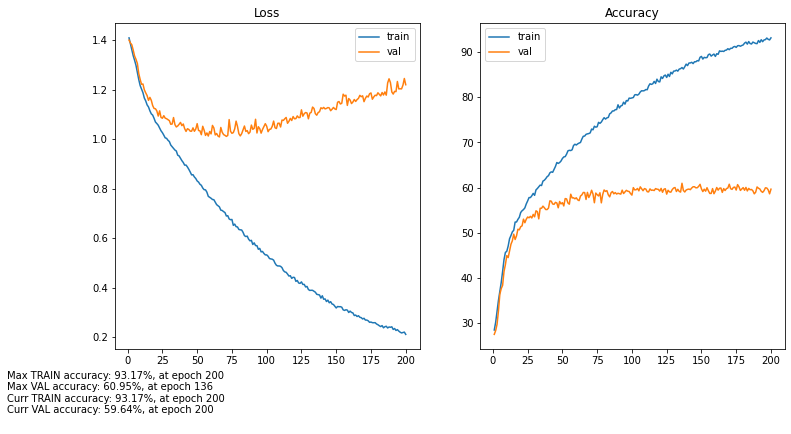

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 50
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv(in_channels=1, classes=4, cnn_drop=0.2, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv(Small), trialsize 400

-- Fold [1/5] --
Epoch [10], Training loss [1.2555], Training accuracy [41.87%]
Epoch [10], Validation loss [1.2542], Validation accuracy [42.17%]
Epoch [20], Training loss [1.1357], Training accuracy [50.27%]
Epoch [20], Validation loss [1.1766], Validation accuracy [47.49%]
Epoch [30], Training loss [1.0500], Training accuracy [55.49%]
Epoch [30], Validation loss [1.1564], Validation accuracy [48.29%]
Epoch [40], Training loss [0.9797], Training accuracy [59.33%]
Epoch [40], Validation loss [1.1283], Validation accuracy [51.09%]
Epoch [50], Training loss [0.9212], Training accuracy [62.19%]
Epoch [50], Validation loss [1.0996], Validation accuracy [53.12%]
Epoch [60], Training loss [0.8615], Training accuracy [65.10%]
Epoch [60], Validation loss [1.1113], Validation accuracy [52.72%]
Epoch [70], Training loss [0.8104], Training accuracy [67.43%]
Epoch [70], Validation loss [1.1550], Validation accuracy [51.14%]
Epoch [80], Training loss [0.7541], Training accuracy [70.23%]
Epoch [80]

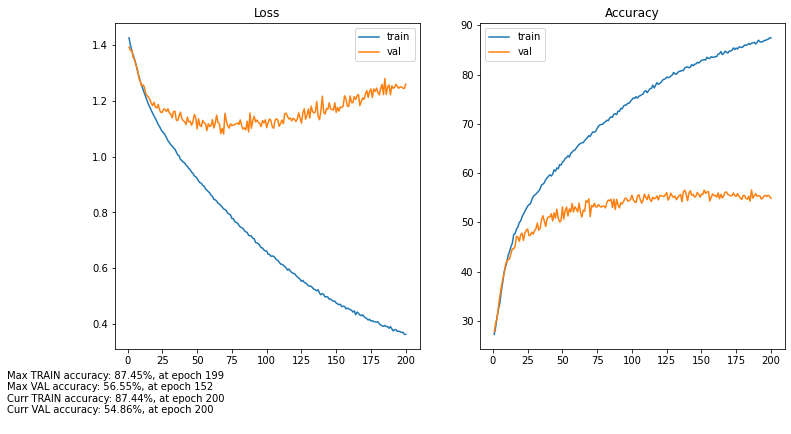

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 400
  stride = 40
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConvSmall(in_channels=1, classes=4, cnn_drop=0.2, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv(Small), trialsize 300

-- Fold [1/5] --
Epoch [10], Training loss [1.2864], Training accuracy [39.93%]
Epoch [10], Validation loss [1.2834], Validation accuracy [39.74%]
Epoch [20], Training loss [1.1906], Training accuracy [46.93%]
Epoch [20], Validation loss [1.2393], Validation accuracy [42.41%]
Epoch [30], Training loss [1.1106], Training accuracy [51.72%]
Epoch [30], Validation loss [1.1919], Validation accuracy [46.62%]
Epoch [40], Training loss [1.0489], Training accuracy [55.44%]
Epoch [40], Validation loss [1.1541], Validation accuracy [49.29%]
Epoch [50], Training loss [0.9900], Training accuracy [58.69%]
Epoch [50], Validation loss [1.1523], Validation accuracy [49.90%]
Epoch [60], Training loss [0.9403], Training accuracy [61.21%]
Epoch [60], Validation loss [1.1347], Validation accuracy [51.72%]
Epoch [70], Training loss [0.8951], Training accuracy [63.65%]
Epoch [70], Validation loss [1.1646], Validation accuracy [50.96%]
Epoch [80], Training loss [0.8483], Training accuracy [66.06%]
Epoch [80]

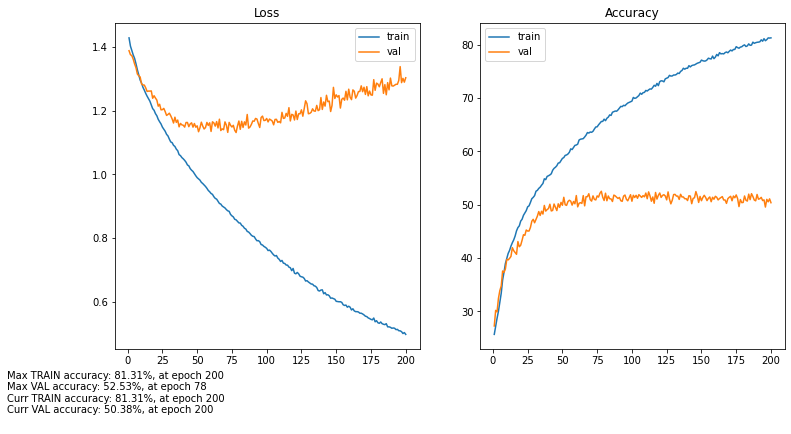

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 300
  stride = 30
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConvSmall(in_channels=1, classes=4, cnn_drop=0.2, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv(Small), trialsize 200

-- Fold [1/5] --
Epoch [10], Training loss [1.2953], Training accuracy [38.64%]
Epoch [10], Validation loss [1.3293], Validation accuracy [36.50%]
Epoch [20], Training loss [1.2266], Training accuracy [44.30%]
Epoch [20], Validation loss [1.2845], Validation accuracy [40.87%]
Epoch [30], Training loss [1.1819], Training accuracy [47.57%]
Epoch [30], Validation loss [1.2635], Validation accuracy [43.07%]
Epoch [40], Training loss [1.1411], Training accuracy [50.08%]
Epoch [40], Validation loss [1.2357], Validation accuracy [44.39%]
Epoch [50], Training loss [1.1083], Training accuracy [52.36%]
Epoch [50], Validation loss [1.2275], Validation accuracy [46.08%]
Epoch [60], Training loss [1.0759], Training accuracy [54.04%]
Epoch [60], Validation loss [1.2110], Validation accuracy [46.94%]
Epoch [70], Training loss [1.0432], Training accuracy [55.69%]
Epoch [70], Validation loss [1.1974], Validation accuracy [47.63%]
Epoch [80], Training loss [1.0192], Training accuracy [57.02%]
Epoch [80]

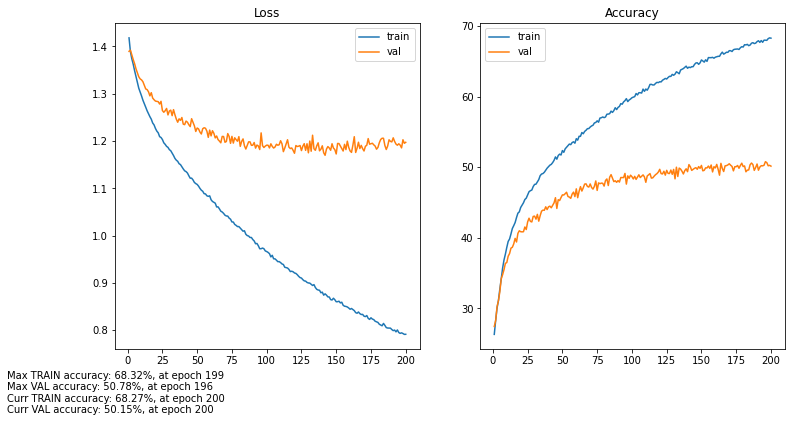

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 200
  stride = 20
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConvSmall(in_channels=1, classes=4, cnn_drop=0.2, trial_length=window_width).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2

-- Fold [1/5] --
Epoch [10], Training loss [1.2098], Training accuracy [44.68%]
Epoch [10], Validation loss [1.2477], Validation accuracy [38.77%]
Epoch [20], Training loss [0.9022], Training accuracy [64.07%]
Epoch [20], Validation loss [1.0767], Validation accuracy [56.03%]
Epoch [30], Training loss [0.6082], Training accuracy [78.84%]
Epoch [30], Validation loss [0.9723], Validation accuracy [61.94%]
Epoch [40], Training loss [0.4518], Training accuracy [84.34%]
Epoch [40], Validation loss [1.0276], Validation accuracy [61.94%]
Epoch [50], Training loss [0.3778], Training accuracy [86.47%]
Epoch [50], Validation loss [0.9933], Validation accuracy [64.54%]
Epoch [60], Training loss [0.2977], Training accuracy [90.19%]
Epoch [60], Validation loss [1.0446], Validation accuracy [65.48%]
Epoch [70], Training loss [0.2426], Training accuracy [92.26%]
Epoch [70], Validation loss [1.0005], Validation accuracy [65.96%]
Epoch [80], Training loss [0.1808], Training accuracy [93.32%]
Epoch [80]

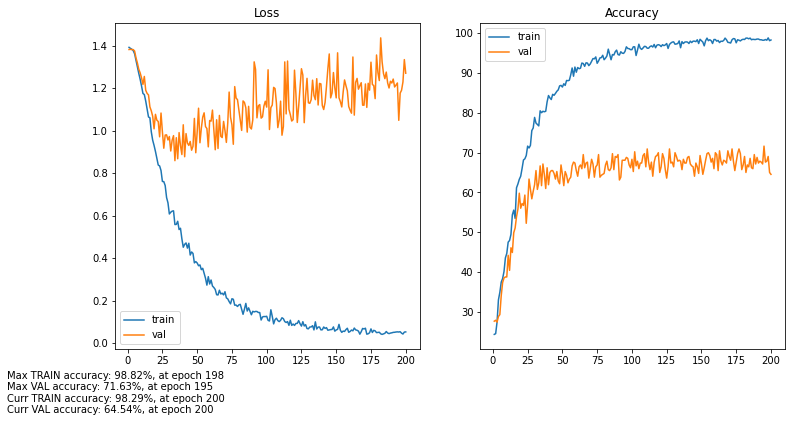

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = False
  VOTE = False
  window_width = 1000
  stride = 100
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# DeepConv2, trialsize 900

-- Fold [1/5] --
Epoch [10], Training loss [1.1091], Training accuracy [52.81%]
Epoch [10], Validation loss [1.2632], Validation accuracy [39.60%]
Epoch [20], Training loss [0.8370], Training accuracy [66.05%]
Epoch [20], Validation loss [1.1428], Validation accuracy [49.76%]
Epoch [30], Training loss [0.5859], Training accuracy [77.93%]
Epoch [30], Validation loss [1.1284], Validation accuracy [57.57%]
Epoch [40], Training loss [0.3770], Training accuracy [86.05%]
Epoch [40], Validation loss [1.1845], Validation accuracy [59.10%]
Epoch [50], Training loss [0.2978], Training accuracy [89.36%]
Epoch [50], Validation loss [1.2236], Validation accuracy [59.93%]
Epoch [60], Training loss [0.2257], Training accuracy [91.73%]
Epoch [60], Validation loss [1.2806], Validation accuracy [59.93%]
Epoch [70], Training loss [0.1792], Training accuracy [93.65%]
Epoch [70], Validation loss [1.4131], Validation accuracy [58.27%]
Epoch [80], Training loss [0.1337], Training accuracy [95.54%]
Epoch [80]

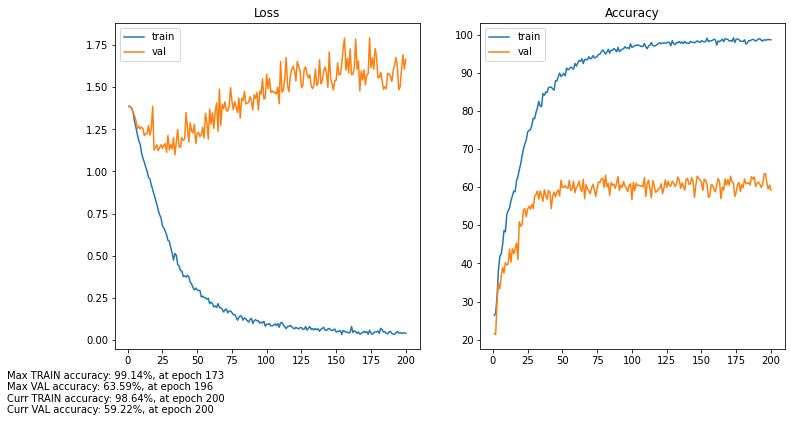

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 900
  stride = 90
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))


# DeepConv2, trialsize 800

-- Fold [1/5] --
Epoch [10], Training loss [0.9726], Training accuracy [60.89%]
Epoch [10], Validation loss [1.0843], Validation accuracy [55.40%]
Epoch [20], Training loss [0.6765], Training accuracy [74.35%]
Epoch [20], Validation loss [1.0867], Validation accuracy [57.60%]
Epoch [30], Training loss [0.4700], Training accuracy [83.04%]
Epoch [30], Validation loss [1.1687], Validation accuracy [58.55%]
Epoch [40], Training loss [0.3233], Training accuracy [88.71%]
Epoch [40], Validation loss [1.2016], Validation accuracy [60.60%]
Epoch [50], Training loss [0.2188], Training accuracy [92.20%]
Epoch [50], Validation loss [1.3630], Validation accuracy [58.55%]
Epoch [60], Training loss [0.1932], Training accuracy [92.95%]
Epoch [60], Validation loss [1.3870], Validation accuracy [59.18%]
Epoch [70], Training loss [0.1246], Training accuracy [95.80%]
Epoch [70], Validation loss [1.3651], Validation accuracy [61.31%]
Epoch [80], Training loss [0.1130], Training accuracy [96.22%]
Epoch [80]

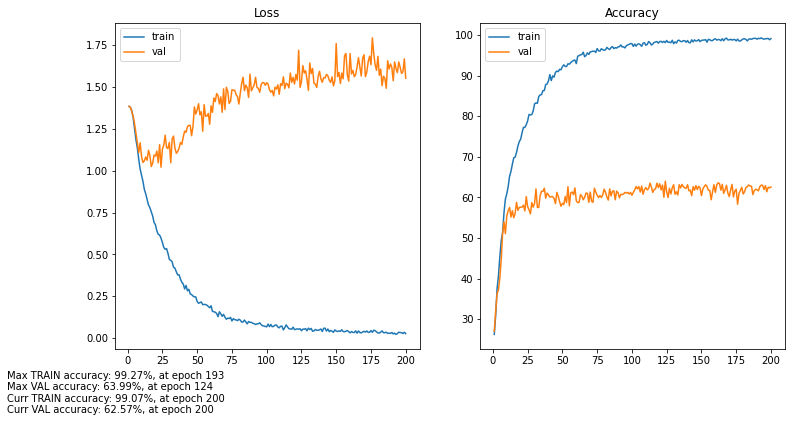

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 800
  stride = 80
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2, trialsize 700

-- Fold [1/5] --
Epoch [10], Training loss [1.1059], Training accuracy [52.58%]
Epoch [10], Validation loss [1.1326], Validation accuracy [50.02%]
Epoch [20], Training loss [0.7945], Training accuracy [69.24%]
Epoch [20], Validation loss [1.0216], Validation accuracy [57.16%]
Epoch [30], Training loss [0.6278], Training accuracy [76.13%]
Epoch [30], Validation loss [1.0061], Validation accuracy [60.43%]
Epoch [40], Training loss [0.4870], Training accuracy [82.29%]
Epoch [40], Validation loss [0.9931], Validation accuracy [62.51%]
Epoch [50], Training loss [0.4023], Training accuracy [85.02%]
Epoch [50], Validation loss [1.1116], Validation accuracy [60.80%]
Epoch [60], Training loss [0.3193], Training accuracy [88.12%]
Epoch [60], Validation loss [1.1199], Validation accuracy [62.36%]
Epoch [70], Training loss [0.2645], Training accuracy [90.67%]
Epoch [70], Validation loss [1.1122], Validation accuracy [63.17%]
Epoch [80], Training loss [0.2183], Training accuracy [91.70%]
Epoch [80]

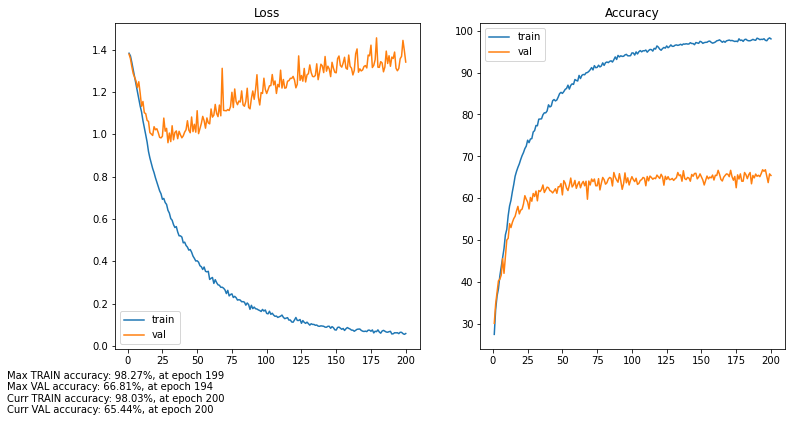

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 700
  stride = 70
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2, trialsize 600

-- Fold [1/5] --
Epoch [10], Training loss [1.1534], Training accuracy [48.57%]
Epoch [10], Validation loss [1.2322], Validation accuracy [44.41%]
Epoch [20], Training loss [0.8989], Training accuracy [64.08%]
Epoch [20], Validation loss [1.1789], Validation accuracy [52.01%]
Epoch [30], Training loss [0.7430], Training accuracy [71.01%]
Epoch [30], Validation loss [1.2017], Validation accuracy [52.99%]
Epoch [40], Training loss [0.6263], Training accuracy [76.12%]
Epoch [40], Validation loss [1.2160], Validation accuracy [53.97%]
Epoch [50], Training loss [0.5116], Training accuracy [80.60%]
Epoch [50], Validation loss [1.1465], Validation accuracy [57.78%]
Epoch [60], Training loss [0.4413], Training accuracy [83.70%]
Epoch [60], Validation loss [1.2361], Validation accuracy [56.87%]
Epoch [70], Training loss [0.3729], Training accuracy [86.46%]
Epoch [70], Validation loss [1.3339], Validation accuracy [56.57%]
Epoch [80], Training loss [0.3135], Training accuracy [88.57%]
Epoch [80]

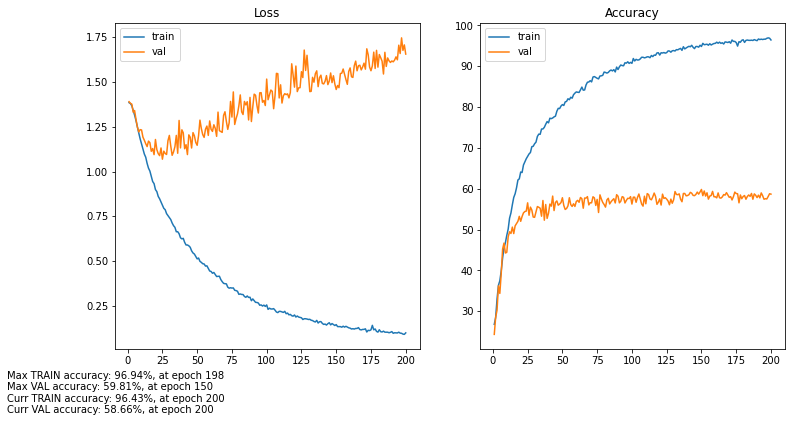

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 600
  stride = 60
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2, trialsize 500

-- Fold [1/5] --
Epoch [10], Training loss [1.2406], Training accuracy [42.28%]
Epoch [10], Validation loss [1.2829], Validation accuracy [37.18%]
Epoch [20], Training loss [1.0004], Training accuracy [58.61%]
Epoch [20], Validation loss [1.1648], Validation accuracy [48.14%]
Epoch [30], Training loss [0.8786], Training accuracy [64.19%]
Epoch [30], Validation loss [1.0642], Validation accuracy [54.93%]
Epoch [40], Training loss [0.7764], Training accuracy [69.17%]
Epoch [40], Validation loss [1.1548], Validation accuracy [51.79%]
Epoch [50], Training loss [0.6911], Training accuracy [72.83%]
Epoch [50], Validation loss [1.0315], Validation accuracy [57.30%]
Epoch [60], Training loss [0.6236], Training accuracy [75.66%]
Epoch [60], Validation loss [1.1652], Validation accuracy [54.20%]
Epoch [70], Training loss [0.5697], Training accuracy [78.07%]
Epoch [70], Validation loss [1.0802], Validation accuracy [56.48%]
Epoch [80], Training loss [0.4985], Training accuracy [80.77%]
Epoch [80]

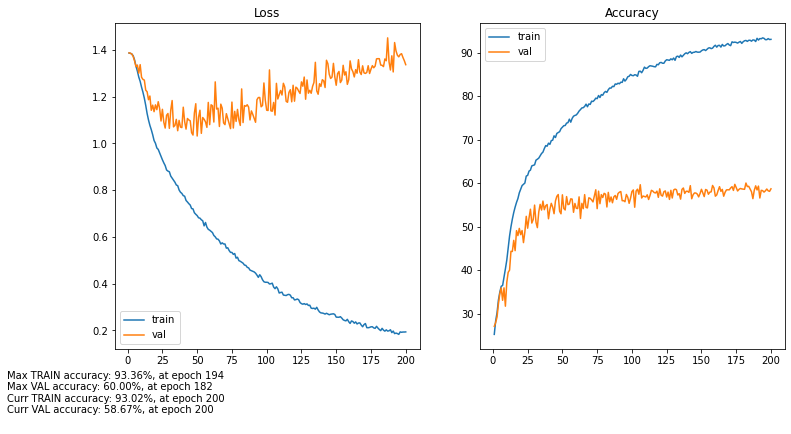

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 500
  stride = 50
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2(Small), trialsize 400

-- Fold [1/5] --
Epoch [10], Training loss [1.1555], Training accuracy [49.44%]
Epoch [10], Validation loss [1.2353], Validation accuracy [44.68%]
Epoch [20], Training loss [0.9929], Training accuracy [58.10%]
Epoch [20], Validation loss [1.1821], Validation accuracy [47.50%]
Epoch [30], Training loss [0.8916], Training accuracy [63.15%]
Epoch [30], Validation loss [1.1371], Validation accuracy [51.74%]
Epoch [40], Training loss [0.8046], Training accuracy [67.54%]
Epoch [40], Validation loss [1.1140], Validation accuracy [53.63%]
Epoch [50], Training loss [0.7323], Training accuracy [70.84%]
Epoch [50], Validation loss [1.1273], Validation accuracy [54.20%]
Epoch [60], Training loss [0.6696], Training accuracy [73.50%]
Epoch [60], Validation loss [1.1273], Validation accuracy [54.91%]
Epoch [70], Training loss [0.6182], Training accuracy [75.88%]
Epoch [70], Validation loss [1.1645], Validation accuracy [54.82%]
Epoch [80], Training loss [0.5680], Training accuracy [77.66%]
Epoch [80]

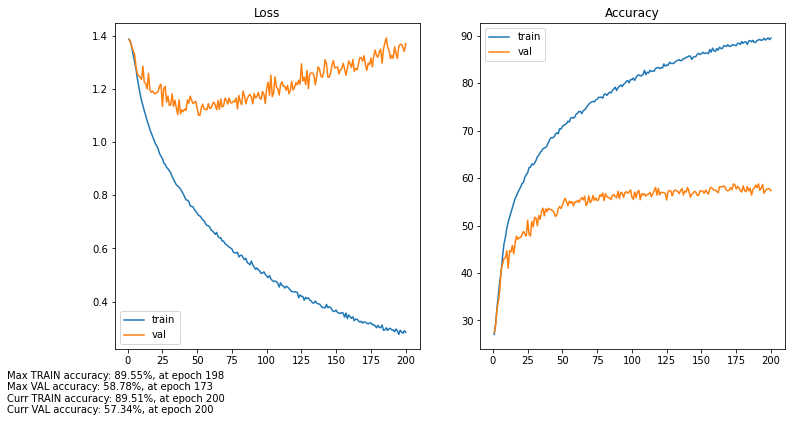

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 400
  stride = 40
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2Small(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2(Small), trialsize 300

-- Fold [1/5] --
Epoch [10], Training loss [1.2232], Training accuracy [43.93%]
Epoch [10], Validation loss [1.2453], Validation accuracy [41.18%]
Epoch [20], Training loss [1.1095], Training accuracy [50.71%]
Epoch [20], Validation loss [1.1911], Validation accuracy [44.97%]
Epoch [30], Training loss [1.0185], Training accuracy [56.08%]
Epoch [30], Validation loss [1.1894], Validation accuracy [48.18%]
Epoch [40], Training loss [0.9295], Training accuracy [60.96%]
Epoch [40], Validation loss [1.1440], Validation accuracy [51.18%]
Epoch [50], Training loss [0.8707], Training accuracy [63.94%]
Epoch [50], Validation loss [1.1537], Validation accuracy [51.53%]
Epoch [60], Training loss [0.8021], Training accuracy [67.32%]
Epoch [60], Validation loss [1.1455], Validation accuracy [52.55%]
Epoch [70], Training loss [0.7579], Training accuracy [69.24%]
Epoch [70], Validation loss [1.1825], Validation accuracy [53.27%]
Epoch [80], Training loss [0.7166], Training accuracy [71.03%]
Epoch [80]

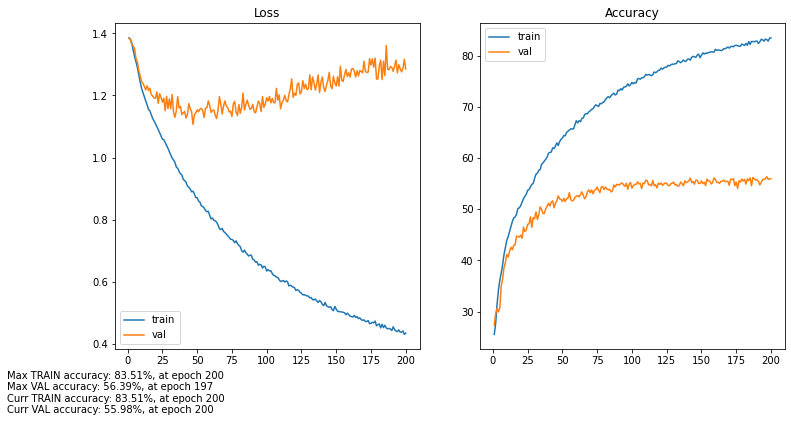

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 300
  stride = 30
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2Small(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))

# DeepConv2(Small), trialsize 200

-- Fold [1/5] --
Epoch [10], Training loss [1.2871], Training accuracy [38.34%]
Epoch [10], Validation loss [1.3272], Validation accuracy [34.92%]
Epoch [20], Training loss [1.1806], Training accuracy [45.97%]
Epoch [20], Validation loss [1.2391], Validation accuracy [40.47%]
Epoch [30], Training loss [1.1159], Training accuracy [49.85%]
Epoch [30], Validation loss [1.2273], Validation accuracy [42.88%]
Epoch [40], Training loss [1.0639], Training accuracy [52.89%]
Epoch [40], Validation loss [1.1901], Validation accuracy [45.44%]
Epoch [50], Training loss [1.0169], Training accuracy [55.57%]
Epoch [50], Validation loss [1.1951], Validation accuracy [46.51%]
Epoch [60], Training loss [0.9743], Training accuracy [58.02%]
Epoch [60], Validation loss [1.1655], Validation accuracy [47.69%]
Epoch [70], Training loss [0.9465], Training accuracy [59.36%]
Epoch [70], Validation loss [1.1586], Validation accuracy [48.52%]
Epoch [80], Training loss [0.9115], Training accuracy [61.39%]
Epoch [80]

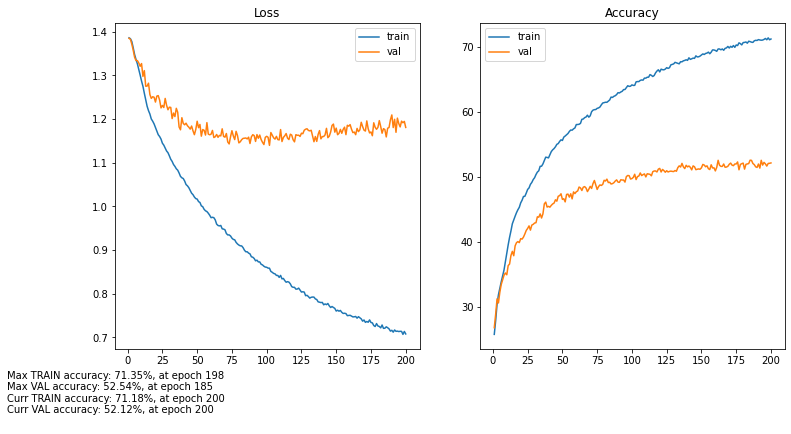

In [ ]:
# Set up cross validation folds, and average accuracy tracker
kf = KFold(n_splits=5, random_state=None, shuffle=True)
avg_accuracy=0
kcount = 1

for k_train_index, k_val_index in kf.split(X_train_valid):
  ## Only compute 1 fold due to computation time:
  if kcount==2:
    break
  ## Print fold
  print('-- Fold [{}/5] --'.format(kcount))

  ## Create this fold's dataloader
  SEGMENT = True
  VOTE = False
  window_width = 200
  stride = 20
  num_slices = int((1000-window_width)/stride+1)

  dataloaders = make_dataloaders(k_train_index, k_val_index, X_train_valid, y_train_valid, X_test, y_test, 
                                 cut=SEGMENT, window_width=window_width, stride=stride, num_slices=num_slices)
  
  ## Create model, hyperpatameters, optimizer, loss function 
  weight_decay = 0.001
  model = DeepConv2Small(in_channels=1, classes=4, cnn_drop=0.2).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay=weight_decay)
  loss_fn = nn.CrossEntropyLoss()
  num_epochs = 200

  ## Start training/validating/training
  # set up per epoch accuracy and loss trackers
  loss_tracker = {'train':[], 'val':[]}
  accuracy_tracker = {'train':[], 'val':[]}
  best_model_params = [0, model]

  for epoch in range(num_epochs): 
    logs = {}
    # train on training samples
    model, epoch_loss_avg, epoch_accuracy = train(model, optimizer, loss_fn, dataloaders, device, epoch)
    loss_tracker['train'].append(epoch_loss_avg)
    accuracy_tracker['train'].append(epoch_accuracy)

    # evalutate on validation samples 
    epoch_loss_avg, epoch_accuracy, best_model_params = validate(model, optimizer, loss_fn, dataloaders, device, epoch, best_model_params)
    loss_tracker['val'].append(epoch_loss_avg)
    accuracy_tracker['val'].append(epoch_accuracy)

  # plot train/validation graph
  make_plot(num_epochs, loss_tracker, accuracy_tracker, saveplot=False)
  # get model weights from the epoch with the highest validation accuracy
  _, final_best_model = best_model_params
  thisacc = finaltest(final_best_model, dataloaders, device)
  print('Test accuracy from the best model during fold [{}] is: [{:.2f}%]'.format(kcount, thisacc))
  kcount += 1
  avg_accuracy += thisacc

print('Average test accuracy of 5-fold validation: [{:.2f}]'.format(avg_accuracy/5))